In [26]:
import pandas as pd
import cv2
import numpy as np
import scipy
import time

import matplotlib.pyplot as plt
%matplotlib inline

source = 0
deg_to_rad = np.pi/180
spat_freq = 0.08

In [27]:
df = pd.read_csv("cell_metrics_VISp.csv")

In [28]:
id_cols = [
    "experiment_container_id", "cell_specimen_id"
]

sg_cols = [
    "pref_ori_sg", "pref_sf_sg", "pref_phase_sg"
]

dg_cols = [
    "pref_dir_dg", "pref_tf_dg"
]

In [29]:
df = df[df["failed_experiment_container"]=="f"]
len(df)

63251

### Video Capturing

In [30]:
window_webcam = "Webcam"
cv2.namedWindow(window_webcam, cv2.WINDOW_NORMAL)

cam = cv2.VideoCapture(source)

In [31]:
dts = []
video = []
T = 10

while sum(dts) < T:
    start = time.time()
    
    _ret, frame = cam.read()
    
    frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    frame_gray = cv2.resize(frame_gray, dsize=None, fx=.5, fy=.5)
    frame_gray = cv2.flip(frame_gray, 1)
    frame_gray_mean = frame_gray.mean()
    frame_gray = (frame_gray - frame_gray_mean) / frame_gray_mean

    cv2.imshow(window_webcam, frame_gray)
    
    frame_gray_norm = (frame_gray - frame_gray.min()) / (frame_gray.max() - frame_gray.min())
    
    video.append(frame_gray_norm)
    
    key = cv2.waitKey(5)
    if key == 27: # exit on ESC
        break
        
    end = time.time()
    dt = end-start
    dts.append(dt)

In [32]:
cv2.destroyAllWindows()
cv2.waitKey(1)

-1

In [33]:
video = np.moveaxis(np.array(video, dtype=np.float16), 0, -1)

frames_per_s = np.ceil(video.shape[-1] / sum(dts))
print(f"Video shape: {video.shape}")
print(f"FPS: {frames_per_s}")

Video shape: (360, 640, 281)
FPS: 29.0


### Sample Dynamic Filters

In [34]:
df_dg = df[id_cols+dg_cols].dropna()

len(df_dg)

29635

In [35]:
df_dg

,experiment_container_id,cell_specimen_id,pref_dir_dg,pref_tf_dg
1,511498742,517397340,0.0,1.0
2,511498742,517397343,180.0,2.0
5,511498742,517397357,135.0,1.0
7,511498742,517397365,180.0,1.0
9,511498742,517397373,225.0,1.0
...,...,...,...,...
63241,712178509,738949092,0.0,2.0
63243,712178509,738949156,180.0,1.0
63245,712178509,738949207,0.0,2.0
63248,712178509,738949318,45.0,1.0


In [36]:
n_filters = 2

df_dg_sample = df_dg.sample(n_filters)

gs = [
    np.moveaxis(np.array([
        cv2.getGaborKernel(
            ksize=(80,80),
            sigma=40,
            theta=r['pref_dir_dg']*deg_to_rad,
            lambd=1/spat_freq,
            gamma=1,
            psi=i*2*np.pi,
        )
        for i in np.linspace(0, 1, int(frames_per_s/r['pref_tf_dg']))
    ], dtype=np.float16), 0, -1)
    for _, r in df_dg_sample.iterrows()
]

oris = [r['pref_dir_dg'] for _, r in df_dg_sample.iterrows()]
t_freqs = [r['pref_tf_dg'] for _, r in df_dg_sample.iterrows()]

(81, 81, 29)


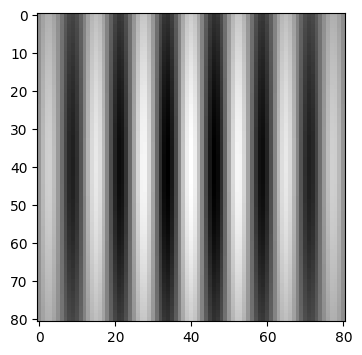


(81, 81, 1)


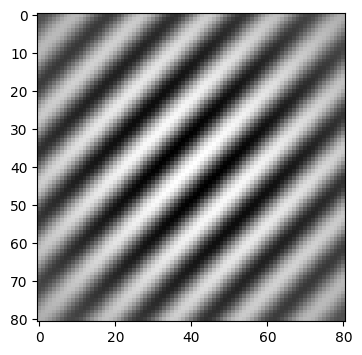

In [37]:
for g_t in gs:    
    print(g_t.shape)
    plt.figure(figsize=(5, 4))
    plt.imshow(g_t[:,:,0], cmap='gray')
    plt.show()
    print()

In [39]:
video_conv_dict = {}

In [40]:
for g_idx, g_t in enumerate(gs):
    print(f"Kernel {g_idx}")
    print(video.shape, video.dtype, flush=True)
    print(g_t.shape, g_t.dtype, flush=True)
    print("ready!", flush=True)
    video_conv = scipy.signal.fftconvolve(
        video,
        g_t,
        mode='full',
    )

    print("convolution done!", flush=True)
    print("ready to normalize!", flush=True)

    video_conv = 255*(video_conv - video_conv.min())/(video_conv.max() - video_conv.min())
    video_conv_dict[g_idx] = video_conv
    
    print()

Kernel 0
(360, 640, 281) float16
(81, 81, 29) float16
ready!
convolution done!
ready to normalize!

Kernel 1
(360, 640, 281) float16
(81, 81, 1) float16
ready!
convolution done!
ready to normalize!



In [24]:
window_filter = f"Filter 0"
cv2.namedWindow(window_filter, cv2.WINDOW_NORMAL)

In [25]:
video_conv = video_conv_dict[0]

for idx in range(video_conv.shape[-1]):
    cv2.imshow(window_filter, video_conv[:,:,idx])
    
    key = cv2.waitKey(5)
    if key == 27: # exit on ESC
        break
        
    time.sleep(1/frames_per_s)
    
cv2.destroyAllWindows()
cv2.waitKey(1)

KeyboardInterrupt: 

# 